In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../')

In [3]:
import socib_modelling_python as mff
from socib_modelling_python.miner import get_glider_missions, get_metadata_remote_file, find_latest_in_remote_files
from socib_modelling_python.batch.gliders import compute_glider_transect, compute_glider_transect_canales
from socib_modelling_python.io import read as mff_read
from socib_modelling_python.batch import load_oceanic_model
from socib_modelling_python.compute.seawater import press2depth

In [4]:
from socib_modelling_python.config import Config as MFF_Config

In [5]:
from datetime import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import cm
import xarray as xr
import numpy as np

# Searching and IO operations with gliders
## Get the glider mission in a period of time

In [6]:
after = dt(2020, 10, 1)
before = dt(2020, 12, 31)
payload = dict(workers=10, after=after, before=before)

The payload variable will be used to set some filters.  
In the example, we set a period between `after` and `before` to limit the results.  
Also, we set up 10 workers, so the searching task will be splitted among 10 crawlers.  
Now, we can call the `function get_glider_missions` from `socib_modelling_python.miner` to perform the search.  
Our payload dictionary should be pass via `crawler_kwargs` parameter.  
This parameters is propagated to the threadds crawler object.

In [7]:
missions = get_glider_missions(crawler_kwargs=payload)

In [8]:
missions

['http://thredds.socib.es/thredds/dodsC/auv/glider/sdeep06-scb_sldeep006/L2/2020/dep0001_sdeep06_scb-sldeep006_L2_2020-12-01_data_rt.nc',
 'http://thredds.socib.es/thredds/dodsC/auv/glider/sdeep06-scb_sldeep006/L2/2020/dep0001_sdeep06_scb-sldeep006_L2_2020-12-01_data_dt.nc',
 'http://thredds.socib.es/thredds/dodsC/auv/glider/sdeep06-scb_sldeep006/L1/2020/dep0001_sdeep06_scb-sldeep006_L1_2020-12-01_data_rt.nc',
 'http://thredds.socib.es/thredds/dodsC/auv/glider/sdeep06-scb_sldeep006/L1/2020/dep0001_sdeep06_scb-sldeep006_L1_2020-12-01_data_dt.nc',
 'http://thredds.socib.es/thredds/dodsC/auv/glider/sdeep06-scb_sldeep006/L1/2020/dep0001_sdeep06_scb-sldeep006_L1_2020-12-01.nc',
 'http://thredds.socib.es/thredds/dodsC/auv/glider/sdeep06-scb_sldeep006/L0/2020/dep0001_sdeep06_scb-sldeep006_L0_2020-12-01_data_rt.nc',
 'http://thredds.socib.es/thredds/dodsC/auv/glider/sdeep06-scb_sldeep006/L0/2020/dep0001_sdeep06_scb-sldeep006_L0_2020-12-01_data_dt.nc',
 'http://thredds.socib.es/thredds/dodsC/au

As we can see, the searching returned multiple Opendap urls.  
Because we have not filter/selected other parameters, some missions have more than one url.  
For example, we could set a processing level (e.g. L0, L1, or L2) or a data type (rt or dt).  
Lets try it.

In [9]:
processing_level = "(L2)"
data_type = "(dt)"
select = [processing_level, data_type]
payload = dict(workers=10, after=after, before=before, select=select)

Other filters than `after` and `before` need to be set in a list of patterns.  
Each pattern is a string that is inside `()`.  
Finally, the list of patterns is send to the crawler via the `select` payload.

In [10]:
missions = get_glider_missions(crawler_kwargs=payload)

In [11]:
missions

['http://thredds.socib.es/thredds/dodsC/auv/glider/sdeep06-scb_sldeep006/L2/2020/dep0001_sdeep06_scb-sldeep006_L2_2020-12-01_data_dt.nc',
 'http://thredds.socib.es/thredds/dodsC/auv/glider/sdeep04-scb_sldeep004/L2/2020/dep0019_sdeep04_scb-sldeep004_L2_2020-09-29_data_dt.nc']

The same way we can define filters to `select` some pattern, we can `skip` some patterns.  
In a similar way, we now define a list of patterns to be skipped.

In [12]:
processing_level_skip = "(L0)"
data_type = "(rt)"
select = [data_type]
skip = [processing_level_skip]
payload = dict(workers=10, after=after, before=before, select=select, skip=skip)

In [13]:
missions = get_glider_missions(crawler_kwargs=payload)

In [14]:
missions

['http://thredds.socib.es/thredds/dodsC/auv/glider/sdeep06-scb_sldeep006/L2/2020/dep0001_sdeep06_scb-sldeep006_L2_2020-12-01_data_rt.nc',
 'http://thredds.socib.es/thredds/dodsC/auv/glider/sdeep06-scb_sldeep006/L1/2020/dep0001_sdeep06_scb-sldeep006_L1_2020-12-01_data_rt.nc',
 'http://thredds.socib.es/thredds/dodsC/auv/glider/sdeep04-scb_sldeep004/L2/2020/dep0020_sdeep04_scb-sldeep004_L2_2020-11-13_data_rt.nc',
 'http://thredds.socib.es/thredds/dodsC/auv/glider/sdeep04-scb_sldeep004/L2/2020/dep0019_sdeep04_scb-sldeep004_L2_2020-09-29_data_rt.nc',
 'http://thredds.socib.es/thredds/dodsC/auv/glider/sdeep04-scb_sldeep004/L1/2020/dep0020_sdeep04_scb-sldeep004_L1_2020-11-13_data_rt.nc',
 'http://thredds.socib.es/thredds/dodsC/auv/glider/sdeep04-scb_sldeep004/L1/2020/dep0019_sdeep04_scb-sldeep004_L1_2020-09-29_data_rt.nc']

## Get metadata from a glider mission
Using the `get_metadata_remote_file` from `socib_modelling_python.miner` we can get the metadata of a file hosted in a thredds server.  
This can be useful when we want to check some properties of the file before download its data.  
The metadata will be a dictionary, the information inside this dictionary will depends of each file.  

In [15]:
metadata = get_metadata_remote_file(missions[0])

In [16]:
metadata

{'abstract': 'First deployment of Slocum G3 deep glider sdeep06 in a trial mission. It will perform 7-10 days of ENG test in DEC 2020, and also sampling physical and biogeochemical parmeters (CTD, BSK, fluorescence and turibity, oxygen, and PAR).\n',
 'acknowledgement': 'Ministerio de EconomÃ\xada y Competitividad (http://www.idi.mineco.gob.es/). Govern de les Illes Balears (http://www.caib.es/).',
 'author': 'SOCIB Glider facility',
 'author_email': 'glidertech@socib.es',
 'cdm_data_type': 'Trajectory',
 'citation': 'Ministerio de EconomÃ\xada y Competitividad (http://www.idi.mineco.gob.es/). Govern de les Illes Balears (http://www.caib.es/).',
 'comment': 'Instantaneous regularly sampled vertical profiles generated from depth binning of already processed (regularized, corrected and/or derived) glider data.',
 'Conventions': 'CF-1.6',
 'creator': 'SOCIB Glider facility',
 'creator_email': 'glidertech@socib.es',
 'creator_url': 'http://www.socib.es/?seccion=observingFacilities&facility

Commonly, the data hosted on SOCIB thredds has information about geospatial limits and time coverage.

In [17]:
for m in missions:
    metadata = get_metadata_remote_file(m)
    print(f"Mission: {m}")
    print(f"-------: Time Coverage between {metadata['time_coverage_start']} and {metadata['time_coverage_end']}")
    geolimits = [metadata[l] for l in ["geospatial_lon_min", "geospatial_lon_max", "geospatial_lat_min", "geospatial_lat_max"]]
    print(f"-------: Geospatial Coverage between LONS [{geolimits[0]}, {geolimits[1]}] and LATS [{geolimits[2]}, {geolimits[3]}]")

Mission: http://thredds.socib.es/thredds/dodsC/auv/glider/sdeep06-scb_sldeep006/L2/2020/dep0001_sdeep06_scb-sldeep006_L2_2020-12-01_data_rt.nc
-------: Time Coverage between 2020-12-01T15:06:28+00:00 and 2020-12-08T07:52:45+00:00
-------: Geospatial Coverage between LONS [2.4467069309536966, 2.4964583383800827] and LATS [39.19431365417103, 39.279522876888414]
Mission: http://thredds.socib.es/thredds/dodsC/auv/glider/sdeep06-scb_sldeep006/L1/2020/dep0001_sdeep06_scb-sldeep006_L1_2020-12-01_data_rt.nc
-------: Time Coverage between 2020-12-01T11:56:19+00:00 and 2020-12-17T12:44:49+00:00
-------: Geospatial Coverage between LONS [2.443096666666667, 2.5982716666666668] and LATS [39.19329833333334, 39.54853666666667]
Mission: http://thredds.socib.es/thredds/dodsC/auv/glider/sdeep04-scb_sldeep004/L2/2020/dep0020_sdeep04_scb-sldeep004_L2_2020-11-13_data_rt.nc
-------: Time Coverage between 2020-11-13T10:15:20+00:00 and 2020-12-21T18:55:41+00:00
-------: Geospatial Coverage between LONS [0.131

## Get the latest mission
Based on the metadata information, the `find_latest_in_remote_files` from `socib_modelling_python.miner` returns the remote file with the latest data.  

In [18]:
latest_mission = find_latest_in_remote_files(missions)

In [19]:
latest_mission

'http://thredds.socib.es/thredds/dodsC/auv/glider/sdeep04-scb_sldeep004/L1/2020/dep0020_sdeep04_scb-sldeep004_L1_2020-11-13_data_rt.nc'

As we can see, besides the filename indicates that the mission `dep0001_sdeep06_scb-sldeep006_L1_2020-12-01_data_rt.nc` was launch after the mission `dep0020_sdeep04_scb-sldeep004_L2_2020-11-13_data_rt.nc`, in reality the later stayed longer on the water. Thus, `dep0020_sdeep04_scb-sldeep004_L2_2020-11-13_data_rt.nc` has the latest data.

## Reading the mission
To read the mission you can use the library of your preference.  
But, the `socib_modelling_python.io` has a `read` function that supports multiple files formats (e.g. NetCDF and Grib) as well as local and remote files.

In [20]:
data = mff_read(latest_mission)

In [21]:
data

<xarray.Dataset>
Dimensions:                   (time: 129649)
Coordinates:
    depth                     (time) float64 ...
    latitude                  (time) float64 ...
    longitude                 (time) float64 ...
  * time                      (time) datetime64[ns] 2020-11-13T10:06:31.11240...
Data variables: (12/19)
    chlorophyll               (time) float64 ...
    conductivity              (time) float64 ...
    density                   (time) float64 ...
    depth_ctd                 (time) float64 ...
    distance_over_ground      (time) float64 ...
    heading                   (time) float64 ...
    ...                        ...
    salinity                  (time) float64 ...
    temperature               (time) float64 ...
    temperature_oxygen        (time) float64 ...
    turbidity                 (time) float64 ...
    water_velocity_eastward   (time) float64 ...
    water_velocity_northward  (time) float64 ...
Attributes: (12/47)
    abstract:                        Deployment of Slocum G2 deep glider sdee...
    acknowledgement:                 Ministerio de Economía y Competitividad ...
    author:                          SOCIB Glider facility
    author_email:                    glidertech@socib.es
    cdm_data_type:                   Trajectory
    citation:                        Ministerio de Economía y Competitividad ...
    ...                              ...
    summary:                         Deployment of Slocum G2 deep glider sdee...
    time_coverage_end:               2020-12-21T19:03:49+00:00
    time_coverage_start:             2020-11-13T10:06:31+00:00
    title:                           Glider deployment real time processed data
    transmission_system:             IRIDIUM
    DODS_EXTRA.Unlimited_Dimension:  time

In [22]:
press = data["pressure"]
lats = data["latitude"]
data["depth"] = press2depth(press, lats)

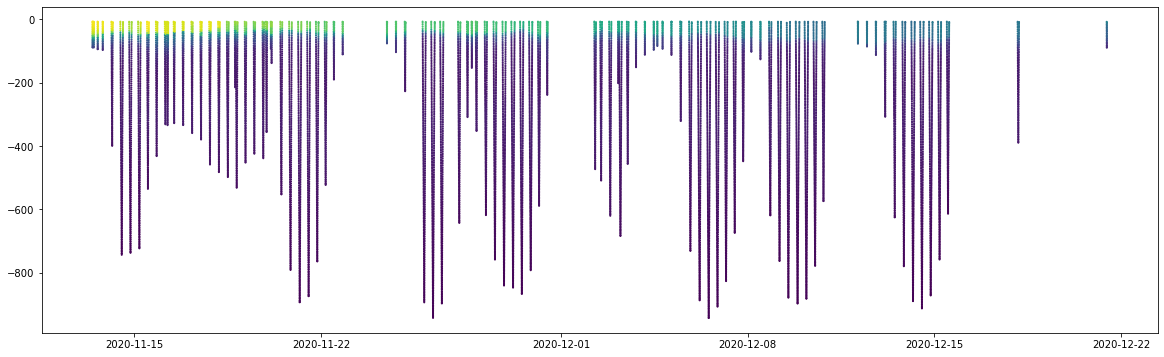

In [23]:
plt.figure(figsize=(20, 6))
plt.scatter(data["time"], -data["depth"], c=data["temperature"], s=1)
plt.show()

## Calculating model transects of a glider mission
The function `compute_glider_transect` provides a way to in one call retrieve the glider data as well as the correspondent transect for a list of oceanographic models.  

In [24]:
transects_all_vars = compute_glider_transect(latest_mission, models=["wmop_3d"])

39it [03:33,  5.47s/it]


In [25]:
transects_all_vars["glider"]

<xarray.Dataset>
Dimensions:                   (time: 129649)
Coordinates:
    depth_coord               (time) float64 nan nan nan nan ... nan nan nan nan
    latitude                  (time) float64 nan nan nan nan ... nan nan nan nan
    longitude                 (time) float64 nan nan nan nan ... nan nan nan nan
  * time                      (time) datetime64[ns] 2020-11-13T10:06:31.11240...
Data variables: (12/20)
    chlorophyll               (time) float64 ...
    conductivity              (time) float64 ...
    density                   (time) float64 ...
    depth_ctd                 (time) float64 ...
    distance_over_ground      (time) float64 ...
    heading                   (time) float64 ...
    ...                        ...
    temperature               (time) float64 ...
    temperature_oxygen        (time) float64 ...
    turbidity                 (time) float64 ...
    water_velocity_eastward   (time) float64 ...
    water_velocity_northward  (time) float64 ...
    depth                     (time) float64 nan nan nan nan ... nan nan nan nan
Attributes: (12/48)
    abstract:                        Deployment of Slocum G2 deep glider sdee...
    acknowledgement:                 Ministerio de Economía y Competitividad ...
    author:                          SOCIB Glider facility
    author_email:                    glidertech@socib.es
    cdm_data_type:                   Trajectory
    citation:                        Ministerio de Economía y Competitividad ...
    ...                              ...
    time_coverage_end:               2020-12-21T19:03:49+00:00
    time_coverage_start:             2020-11-13T10:06:31+00:00
    title:                           Glider deployment real time processed data
    transmission_system:             IRIDIUM
    DODS_EXTRA.Unlimited_Dimension:  time
    mission:                         dep0020_sdeep04_scb-sldeep004_L1_2020-11...

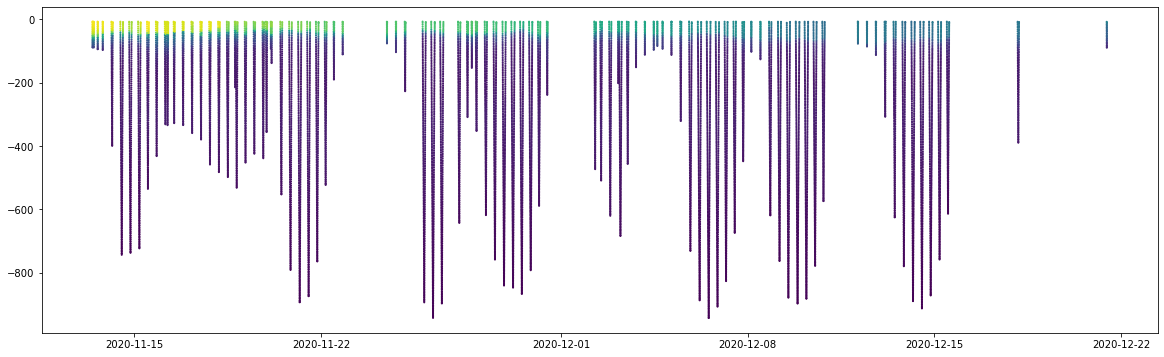

In [26]:
plt.figure(figsize=(20, 6))
plt.scatter(transects_all_vars["glider"]["time"], -transects_all_vars["glider"]["depth"], c=transects_all_vars["glider"]["temperature"], s=1)
plt.show()

In [27]:
transects_all_vars["wmop_3d"]

<xarray.Dataset>
Dimensions:             (time: 129649)
Coordinates:
    depth               (time) float64 nan nan nan nan nan ... nan nan nan nan
    depth_coord         (time) float64 nan nan nan nan nan ... nan nan nan nan
    latitude            (time) float64 nan nan nan nan nan ... nan nan nan nan
    longitude           (time) float64 nan nan nan nan nan ... nan nan nan nan
  * time                (time) datetime64[ns] 2020-11-13T10:06:31.112400128 ....
Data variables:
    temp                (time) float32 nan nan nan nan nan ... nan nan nan nan
    salt                (time) float32 nan nan nan nan nan ... nan nan nan nan
    u                   (time) float32 nan nan nan nan nan ... nan nan nan nan
    v                   (time) float32 nan nan nan nan nan ... nan nan nan nan
    zeta                (time) float32 nan nan nan nan nan ... nan nan nan nan
    sst_gradients       (time) float32 nan nan nan nan nan ... nan nan nan nan
    sss_gradients       (time) float32 nan nan nan nan nan ... nan nan nan nan
    surface_divergence  (time) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    file:                            WMOP regular daily average file
    institution:                     SOCIB
    fullname:                        Balearic Islands Coastal Observing and F...
    publisher_name:                  SOCIB
    publisher_url:                   www.socib.es
    publisher_email:                 info@socib.es
    date:                            13-Nov-2020 10:20:40 CET
    DODS_EXTRA.Unlimited_Dimension:  ocean_time

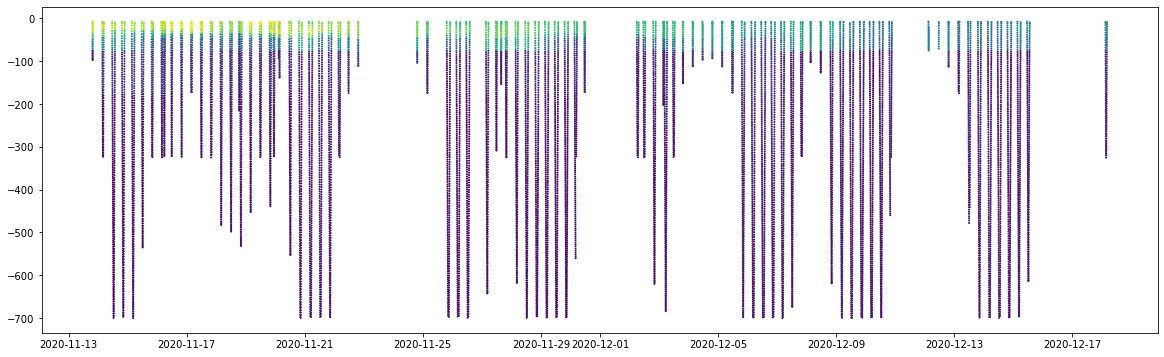

In [28]:
plt.figure(figsize=(20, 6))
plt.scatter(transects_all_vars["wmop_3d"]["time"], -transects_all_vars["wmop_3d"]["depth"], c=transects_all_vars["wmop_3d"]["temp"], s=1)
plt.show()

### Calculating model transects of the latest Canales mission
The function `compute_glider_transect_canales` is a specialization of `compute_glider_transect` that automatically returns the transects of the latest canales mission.  
The method searches for the latest mission inside a time period.

In [ ]:
transects_latest_canales = compute_glider_transect_canales(models=["wmop_3d"], period=("20210101", "20211231"), data_type="(rt)|(dt)")

4it [00:20,  5.29s/it]

In [ ]:
transects_latest_canales

In [ ]:
plt.figure(figsize=(20, 6))
plt.scatter(transects_latest_canales["glider"]["time"], -transects_latest_canales["glider"]["depth"], c=transects_latest_canales["glider"]["temperature"], s=1)
plt.colorbar()
plt.show()

In [ ]:
plt.figure(figsize=(20, 6))
plt.scatter(transects_latest_canales["wmop_3d"]["time"], -transects_latest_canales["wmop_3d"]["depth"], c=transects_latest_canales["wmop_3d"]["temp"], s=1)
plt.colorbar()
plt.show()